In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.two_layer_net import TwoLayerNet

%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [8]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [10]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
stats = None
net = TwoLayerNet(input_size, hidden_size, num_classes, reg=0.5, learning_rate=1e-4)
# Train the network
session = tf.Session()
stats = net.train(session, X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200, verbose=True)

# Predict on the validation set
val_acc = (net.predict(session, X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302577
iteration 100 / 1000: loss 2.097877
iteration 200 / 1000: loss 2.079653
iteration 300 / 1000: loss 2.047761
iteration 400 / 1000: loss 2.000476
iteration 500 / 1000: loss 2.051424
iteration 600 / 1000: loss 1.995715
iteration 700 / 1000: loss 1.968463
iteration 800 / 1000: loss 2.020374
iteration 900 / 1000: loss 2.050814
Validation accuracy:  0.473


### Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set in the orignal assignment. This isn't very good. And I change the SGD to Adam, the accuracy is about 0.44.
One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.
Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

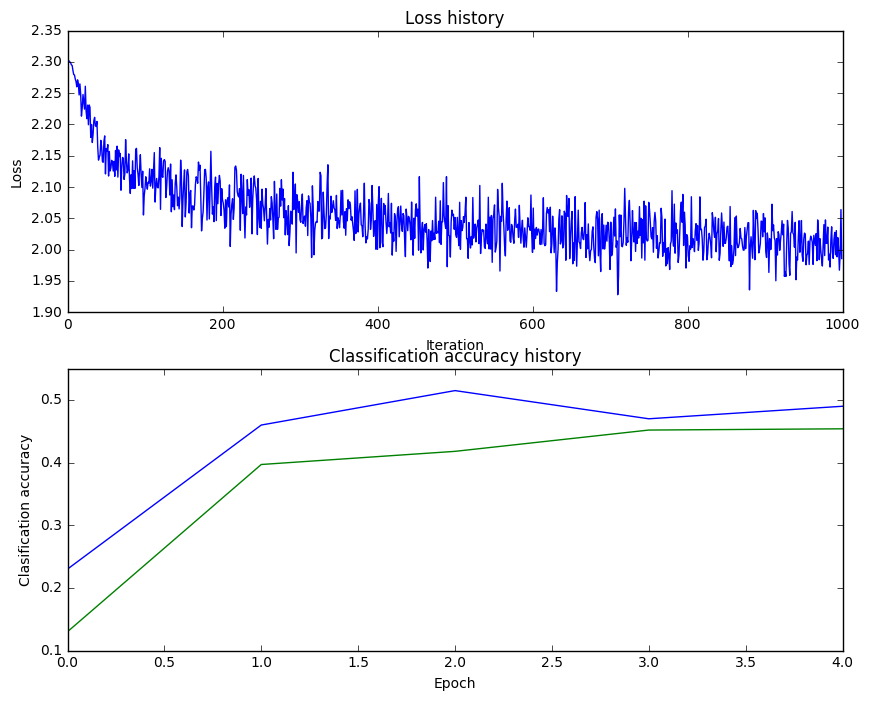

In [11]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

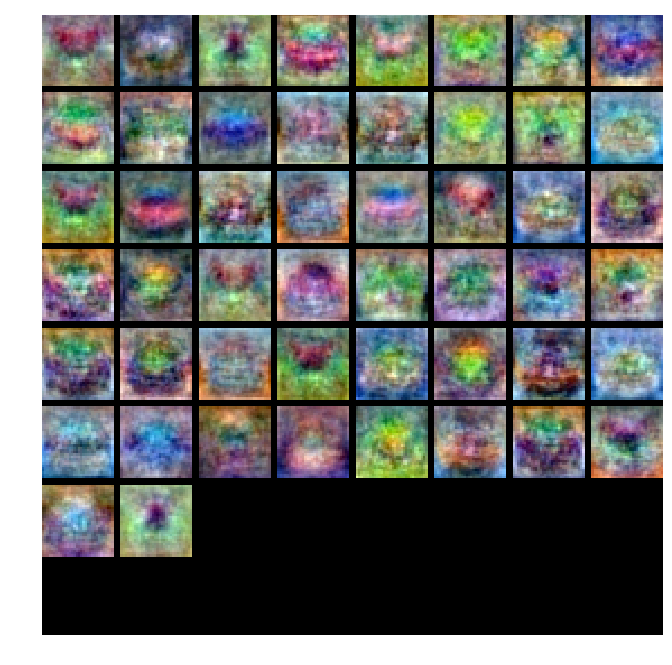

In [12]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net, sess):  
  W1 = net.params['W1'].eval(sess)
  W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
  plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
  plt.gca().axis('off')
  plt.show()

show_net_weights(net, session)
session.close()
session = None
net = None

### Tune your hyperparameters
What's wrong?. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.
Tuning. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.
Approximate results. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.
Experiment: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. For every 1% above 52% on the Test set we will award you with one extra bonus point. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [25]:
best_net = None # store the best model into this 
session = tf.Session()

writer = tf.summary.FileWriter("../tflogs/two_layer/1")

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
hidden_size = [200]

results = {}
best_val_acc = 0
best_net = None
best_session = None

learning_rates = np.array([0.1])*1e-3

regularization_strengths = [0.4]

print('running')
for hs in hidden_size:
    for lr in learning_rates:
        for reg in regularization_strengths:
            writer = tf.summary.FileWriter("/tmp/tflogs/two_layer/hidden_%d_lr_%e_reg_%e" % (hs, lr, reg)) 
            print('.', end='')
            net = TwoLayerNet(input_size, hs, num_classes, learning_rate=lr, reg = reg)

            # Train the network
            stats = net.train(session, X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=200, verbose=False, writer=writer)
            val_acc = (net.predict(session, X_val) == y_val).mean()

            if val_acc > best_val_acc:
                old_val_acc = best_val_acc
                best_val_acc = val_acc
                best_net = net
                print('')
                print('Best net changed by new acc = %f, old acc = %f' % (val_acc, old_val_acc))
                print('Best net: hs %d lr %e reg %e ' % (hs, lr, reg))
                if not best_session is None:
                    best_session.close()
                
                best_session = session
                session = tf.Session()
            writer.close()
            results[(hs,lr, reg)] = val_acc

print(' ')
print("finished")
# Print out results.
for hs,lr, reg in sorted(results):
    val_acc = results[(hs, lr, reg)]
    print('hs %d lr %e reg %e val accuracy: %f' % (hs, lr, reg, val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val_acc)
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

running
.
Best net changed by new acc = 0.500000, old acc = 0.000000
Best net: hs 200 lr 1.000000e-04 reg 4.000000e-01 
 
finished
hs 200 lr 1.000000e-04 reg 4.000000e-01 val accuracy: 0.500000
best validation accuracy achieved during cross-validation: 0.500000


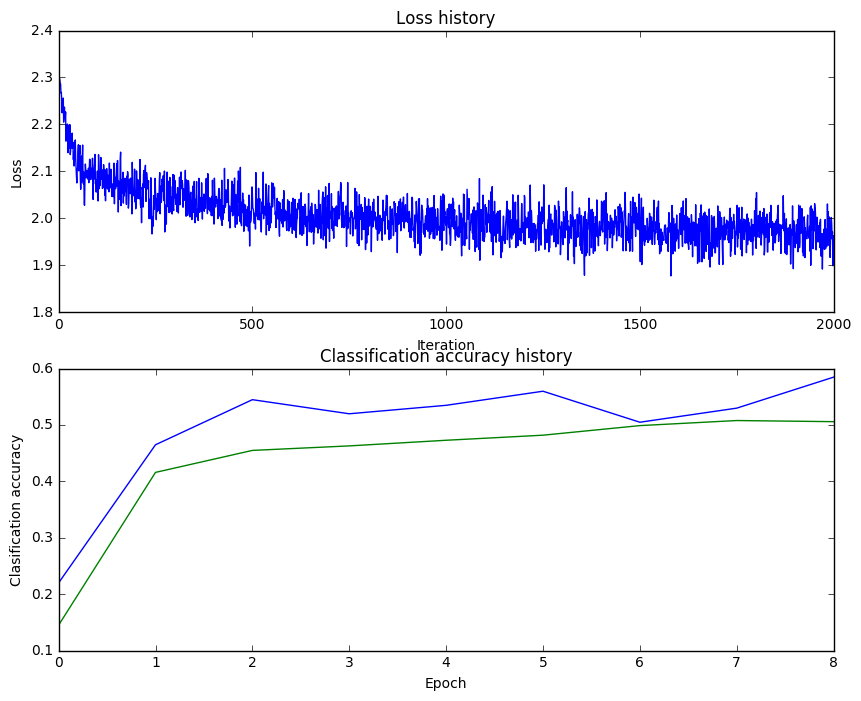

In [26]:
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

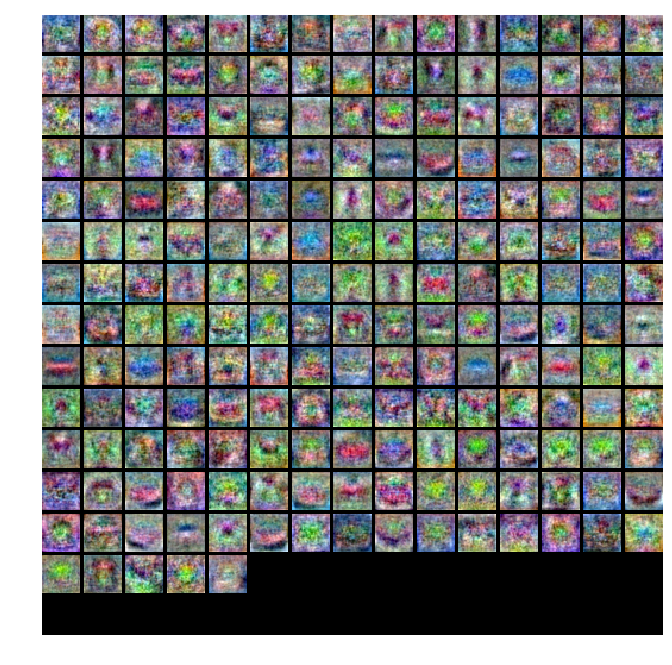

In [27]:
# visualize the weights of the best network
show_net_weights(best_net, best_session)

### Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.
#### We will give you extra bonus point for every 1% of accuracy above 52%.

In [28]:
test_acc = (best_net.predict(best_session, X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.477


In [29]:
session.close()
session = None
best_net = None

In [30]:
best_session.close()